# **CSC 366 GROUP 5**


In [ ]:
from bs4 import BeautifulSoup
import requests, re, json
import pandas as pd
import csv
from google.colab import userdata

# **=====================================================================**

## **We will be using the 2024 Fair Market Rent(fmr) API dataset from HUD’s Office of Policy Development and Research (PD&R)**
(https://www.huduser.gov/portal/dataset/fmr-api.html)
(https://www.huduser.gov/portal/datasets/fmr.html#query_2025)

In [ ]:
base_url = "https://www.huduser.gov/hudapi/public/fmr/listStates"
api_key = userdata.get('HUD_API_KEY')
header = {"Authorization": f"Bearer {api_key}"}

**In this section I am just testing if the API connection works**

In [ ]:
def get_states():
    response = requests.get(base_url, headers=header)
    print("Status Code:", response.status_code)

    if response.status_code == 200:
      data = response.json()
      return data
    else:
      print("failed")
      return None

states_data = get_states()
print(states_data)

Status Code: 200
[{'state_name': 'Alabama', 'state_code': 'AL', 'state_num': '1.0', 'category': 'State'}, {'state_name': 'Alaska', 'state_code': 'AK', 'state_num': '2.0', 'category': 'State'}, {'state_name': 'American Samoa', 'state_code': 'AS', 'state_num': '60.0', 'category': 'State'}, {'state_name': 'Arizona', 'state_code': 'AZ', 'state_num': '4.0', 'category': 'State'}, {'state_name': 'Arkansas', 'state_code': 'AR', 'state_num': '5.0', 'category': 'State'}, {'state_name': 'California', 'state_code': 'CA', 'state_num': '6.0', 'category': 'State'}, {'state_name': 'Colorado', 'state_code': 'CO', 'state_num': '8.0', 'category': 'State'}, {'state_name': 'Connecticut', 'state_code': 'CT', 'state_num': '9.0', 'category': 'State'}, {'state_name': 'Delaware', 'state_code': 'DE', 'state_num': '10.0', 'category': 'State'}, {'state_name': 'District of Columbia', 'state_code': 'DC', 'state_num': '11.0', 'category': 'State'}, {'state_name': 'Florida', 'state_code': 'FL', 'state_num': '12.0', 'ca

In [ ]:
def get_state_rent(state_code):
    url = f"https://www.huduser.gov/hudapi/public/fmr/statedata/{state_code}?year=2024"
    response = requests.get(url, headers=header)

    if response.status_code == 200:
      data = response.json()
      return data
    else:
      print("Failed")
      return None

alabama_rent = get_state_rent('AL')
print(alabama_rent)


{'data': {'year': '2024', 'metroareas': [{'metro_name': 'Anniston-Oxford-Jacksonville, AL MSA', 'code': 'METRO11500M11500', 'Efficiency': 683, 'One-Bedroom': 687, 'Two-Bedroom': 903, 'Three-Bedroom': 1243, 'Four-Bedroom': 1319, 'FMR Percentile': 40, 'statename': 'Alabama', 'statecode': 'AL', 'smallarea_status': '0'}, {'metro_name': 'Auburn-Opelika, AL MSA', 'code': 'METRO12220M12220', 'Efficiency': 801, 'One-Bedroom': 901, 'Two-Bedroom': 1099, 'Three-Bedroom': 1487, 'Four-Bedroom': 1617, 'FMR Percentile': 40, 'statename': 'Alabama', 'statecode': 'AL', 'smallarea_status': '0'}, {'metro_name': 'Birmingham-Hoover, AL HUD Metro FMR Area', 'code': 'METRO13820M13820', 'Efficiency': 983, 'One-Bedroom': 1109, 'Two-Bedroom': 1245, 'Three-Bedroom': 1570, 'Four-Bedroom': 1752, 'FMR Percentile': 40, 'statename': 'Alabama', 'statecode': 'AL', 'smallarea_status': '0'}, {'metro_name': 'Chilton County, AL HUD Metro FMR Area', 'code': 'METRO13820N01021', 'Efficiency': 682, 'One-Bedroom': 690, 'Two-Bedr

**For each state, there is metro and counties areas. We will gather the specific columns or information we want from the API and add it to a list.**

In [ ]:
final_data = []

In [ ]:
for state in states_data:
    code = state['state_code']
    name = state['state_name']

    rent_data = get_state_rent(code)

    if rent_data and "data" in rent_data:
        for entry in rent_data["data"].get("metroareas", []):
            final_data.append({
                "state": name,
                "location_type": "metro",
                "name": entry.get("metro_name"),
                "Studio": entry.get("Efficiency"),
                "1_bed": entry.get("One-Bedroom"),
                "2_bed": entry.get("Two-Bedroom"),
                "3_bed": entry.get("Three-Bedroom"),
                "4_bed": entry.get("Four-Bedroom"),
            })
        for entry in rent_data["data"].get("counties", []):
             final_data.append({
                "state": name,
                "location_type": "county",
                "name": entry.get("county_name"),
                "Studio": entry.get("Efficiency"),
                "1_bed": entry.get("One-Bedroom"),
                "2_bed": entry.get("Two-Bedroom"),
                "3_bed": entry.get("Three-Bedroom"),
                "4_bed": entry.get("Four-Bedroom"),
            })

**Turning the list into a dataframe**

In [ ]:
df_rent = pd.DataFrame(final_data)
df_rent.head()

,state,location_type,name,Studio,1_bed,2_bed,3_bed,4_bed
0,Alabama,metro,"Anniston-Oxford-Jacksonville, AL MSA",683,687,903,1243,1319
1,Alabama,metro,"Auburn-Opelika, AL MSA",801,901,1099,1487,1617
2,Alabama,metro,"Birmingham-Hoover, AL HUD Metro FMR Area",983,1109,1245,1570,1752
3,Alabama,metro,"Chilton County, AL HUD Metro FMR Area",682,690,857,1164,1168
4,Alabama,metro,"Columbus, GA-AL HUD Metro FMR Area",828,881,1031,1372,1743


**I am making sure there is only 50 states, and no extra territories, and if there is I will drop them because if not it will affect the minimum wage dataset with null values.**

In [ ]:
df_rent['state'].nunique()

56

In [ ]:
df_rent['state'].unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Isl', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [ ]:
territories_to_drop = ['Northern Mariana Isl', 'American Samoa', 'Virgin Islands', 'Guam', 'District of Columbia', 'Puerto Rico']
df_rent = df_rent.drop(df_rent[df_rent['state'].isin(territories_to_drop)].index)

In [ ]:
df_rent['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [ ]:
df_rent['state'].nunique()

50

**We will be calculating the average of the (studio, 1bed,2bed, 3bed,and 4bed) to calcaulte the average rent for each county/metro.**

This will help keep the dataset more concise and clear

In [ ]:
df_rent['avg_rent'] = df_rent[['Studio','1_bed', '2_bed', '3_bed', '4_bed']].astype(float).mean(axis=1)

**An example:**

In [ ]:
new_york_data = df_rent[(df_rent['state'] == 'New York') & (df_rent['location_type'] == 'county')]
new_york_data.head(60)

,state,location_type,name,Studio,1_bed,2_bed,3_bed,4_bed,avg_rent
3504,New York,county,Albany County,1011,1131,1374,1661,1830,1401.4
3505,New York,county,Allegany County,676,731,905,1130,1288,946.0
3506,New York,county,Bronx County,2386,2451,2752,3434,3700,2944.6
3507,New York,county,Broome County,855,904,1141,1494,1644,1207.6
3508,New York,county,Cattaraugus County,705,709,905,1138,1291,949.6
3509,New York,county,Cayuga County,728,733,958,1210,1409,1007.6
3510,New York,county,Chautauqua County,662,711,905,1168,1205,930.2
3511,New York,county,Chemung County,905,922,1208,1560,1697,1258.4
3512,New York,county,Chenango County,672,777,905,1214,1354,984.4
3513,New York,county,Clinton County,821,826,1047,1283,1395,1074.4


In [ ]:
df_rent.to_csv("fair_market_rent_2024.csv", index=False)

# **=====================================================================**

## **Gathering the minimum wage**
We will be using the technique web scraping to gather the hourly rate for each state. Then I will turn this data into a dataframe, so I can merged it with the rent dataset.
(https://www.richstatespoorstates.org/variables/state_minimum_wage/)

In [ ]:
page_to_scrape=requests.get("https://www.richstatespoorstates.org/variables/state_minimum_wage/")
soup=BeautifulSoup(page_to_scrape.text,'html.parser' )

In [ ]:
rows = soup.find('tbody').find_all('tr')

In [ ]:
data = []
for row in rows:
    cols = row.find_all('td')
    state = cols[0].get_text(strip=True)
    wage = float(cols[1]['data-order'])
    data.append({'state': state, 'minimum_wage': wage})

In [ ]:
df_min_wage = pd.DataFrame(data)
df_min_wage

,state,minimum_wage
0,Alabama,7.25
1,Alaska,11.91
2,Arizona,14.70
3,Arkansas,11.00
4,California,16.50
5,Colorado,14.81
6,Connecticut,16.35
7,Delaware,15.00
8,Florida,13.00
9,Georgia,7.25


In [ ]:
df_min_wage['state'].nunique()

50

In [ ]:
df_min_wage.to_csv("minimum_wage.csv", index=False)

# **====================================================**

# **Merging Fair Market Rent with Minimum Wage**
I am now combining both datasets, the minimum wage and the rent dataset I had collected.

In [ ]:
df_merged = pd.merge(df_rent, df_min_wage, on='state', how='left')


In [ ]:
df_merged.head()


,state,location_type,name,Studio,1_bed,2_bed,3_bed,4_bed,avg_rent,minimum_wage
0,Alabama,metro,"Anniston-Oxford-Jacksonville, AL MSA",683,687,903,1243,1319,967.0,7.25
1,Alabama,metro,"Auburn-Opelika, AL MSA",801,901,1099,1487,1617,1181.0,7.25
2,Alabama,metro,"Birmingham-Hoover, AL HUD Metro FMR Area",983,1109,1245,1570,1752,1331.8,7.25
3,Alabama,metro,"Chilton County, AL HUD Metro FMR Area",682,690,857,1164,1168,912.2,7.25
4,Alabama,metro,"Columbus, GA-AL HUD Metro FMR Area",828,881,1031,1372,1743,1171.0,7.25


**Affordability will be calculated through hours of Minimum Wage needed for Average Rent. We calculated how many hours a person earning the minimum wage would need to work per month to afford the average rent.**

In [ ]:
# Calculates the monthly income for minimum wage (40/week equals to 160 hours/month)
df_merged['monthly_min_wage_income'] = df_merged['minimum_wage'] * 160

# Calculates the hours needed to afford avg_rent (160 hours/month standard)
df_merged['hours_to_afford_avg_rent'] = df_merged['avg_rent'] / df_merged['minimum_wage']

print("DataFrame with new affordability metrics:")
display(df_merged.head())

DataFrame with new affordability metrics:


,state,location_type,name,Studio,1_bed,2_bed,3_bed,4_bed,avg_rent,minimum_wage,monthly_min_wage_income,hours_to_afford_avg_rent
0,Alabama,metro,"Anniston-Oxford-Jacksonville, AL MSA",683,687,903,1243,1319,967.0,7.25,1160.0,133.379310
1,Alabama,metro,"Auburn-Opelika, AL MSA",801,901,1099,1487,1617,1181.0,7.25,1160.0,162.896552
2,Alabama,metro,"Birmingham-Hoover, AL HUD Metro FMR Area",983,1109,1245,1570,1752,1331.8,7.25,1160.0,183.696552
3,Alabama,metro,"Chilton County, AL HUD Metro FMR Area",682,690,857,1164,1168,912.2,7.25,1160.0,125.820690
4,Alabama,metro,"Columbus, GA-AL HUD Metro FMR Area",828,881,1031,1372,1743,1171.0,7.25,1160.0,161.517241


I converted the merged dataset into a csv file.

In [ ]:
df_merged.to_csv("rent_vs_minwage.csv", index=False)

# **======================================================================**

## **Data Analysis**
I am exploring what the dataset looks like so far, and how many entries it has. I am also checking which columns it has and what the data types for each column is.

In [ ]:
df_merged.head(10)

,state,location_type,name,Studio,1_bed,2_bed,3_bed,4_bed,avg_rent,minimum_wage,monthly_min_wage_income,hours_to_afford_avg_rent
0,Alabama,metro,"Anniston-Oxford-Jacksonville, AL MSA",683,687,903,1243,1319,967.0,7.25,1160.0,133.379310
1,Alabama,metro,"Auburn-Opelika, AL MSA",801,901,1099,1487,1617,1181.0,7.25,1160.0,162.896552
2,Alabama,metro,"Birmingham-Hoover, AL HUD Metro FMR Area",983,1109,1245,1570,1752,1331.8,7.25,1160.0,183.696552
3,Alabama,metro,"Chilton County, AL HUD Metro FMR Area",682,690,857,1164,1168,912.2,7.25,1160.0,125.820690
4,Alabama,metro,"Columbus, GA-AL HUD Metro FMR Area",828,881,1031,1372,1743,1171.0,7.25,1160.0,161.517241
5,Alabama,metro,"Daphne-Fairhope-Foley, AL MSA",1051,1056,1362,1670,2114,1450.6,7.25,1160.0,200.082759
6,Alabama,metro,"Decatur, AL MSA",740,763,924,1202,1352,996.2,7.25,1160.0,137.406897
7,Alabama,metro,"Dothan, AL HUD Metro FMR Area",735,739,904,1220,1386,996.8,7.25,1160.0,137.489655
8,Alabama,metro,"Florence-Muscle Shoals, AL MSA",664,720,940,1157,1425,981.2,7.25,1160.0,135.337931
9,Alabama,metro,"Gadsden, AL MSA",637,817,940,1170,1252,963.2,7.25,1160.0,132.855172


In [ ]:
print(f"The number of rows= {df_merged.shape[0]}")
print(f"The number of columns= {df_merged.shape[1]}")

The number of rows= 5352
The number of columns= 12


In [ ]:
df_merged.columns

Index(['state', 'location_type', 'name', 'Studio', '1_bed', '2_bed', '3_bed',
       '4_bed', 'avg_rent', 'minimum_wage', 'monthly_min_wage_income',
       'hours_to_afford_avg_rent'],
      dtype='object')

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   state                     5352 non-null   object 
 1   location_type             5352 non-null   object 
 2   name                      5352 non-null   object 
 3   Studio                    5352 non-null   int64  
 4   1_bed                     5352 non-null   int64  
 5   2_bed                     5352 non-null   int64  
 6   3_bed                     5352 non-null   int64  
 7   4_bed                     5352 non-null   int64  
 8   avg_rent                  5352 non-null   float64
 9   minimum_wage              5352 non-null   float64
 10  monthly_min_wage_income   5352 non-null   float64
 11  hours_to_afford_avg_rent  5352 non-null   float64
dtypes: float64(4), int64(5), object(3)
memory usage: 501.9+ KB


### **1. Missing Values Check**
I had dealt with missing values earlier before creating the dataset.

In [ ]:
df_merged.isnull().sum()

,0
state,0
location_type,0
name,0
Studio,0
1_bed,0
2_bed,0
3_bed,0
4_bed,0
avg_rent,0
minimum_wage,0


In [ ]:
print("Missing values in df_merged:")
display(df_merged.isnull().sum())

Missing values in df_merged:


,0
state,0
location_type,0
name,0
Studio,0
1_bed,0
2_bed,0
3_bed,0
4_bed,0
avg_rent,0
minimum_wage,0


### **2. Duplicates Check**
I had many duplicated entries from same state, lcoation type, and county name, so i will drop the duplicates and keep unique entries.

In [ ]:
print(f"Number of duplicate rows: {df_merged.duplicated().sum()}")

if df_merged.duplicated().sum() > 0:
    print("Sample of duplicate rows:")
    display(df_merged[df_merged.duplicated(keep=False)].sort_values(by=['state', 'name']).head())

Number of duplicate rows: 1508
Sample of duplicate rows:


,state,location_type,name,Studio,1_bed,2_bed,3_bed,4_bed,avg_rent,minimum_wage,monthly_min_wage_income,hours_to_afford_avg_rent
406,Connecticut,county,Fairfield County,1505,1825,2221,2838,2997,2277.2,16.35,2616.0,139.278287
412,Connecticut,county,Fairfield County,1333,1591,1967,2489,2932,2062.4,16.35,2616.0,126.140673
415,Connecticut,county,Fairfield County,1505,1825,2221,2838,2997,2277.2,16.35,2616.0,139.278287
431,Connecticut,county,Fairfield County,1505,1825,2221,2838,2997,2277.2,16.35,2616.0,139.278287
432,Connecticut,county,Fairfield County,1781,2173,2628,3202,3500,2656.8,16.35,2616.0,162.495413


In [ ]:
df_merged= df_merged.drop_duplicates(subset=['state', 'location_type', 'name'])

print(f"Number of rows after dropping duplicates: {df_merged.shape[0]}")
print(f"Number of duplicate rows: {df_merged.duplicated().sum()}")


Number of rows after dropping duplicates: 3816
Number of duplicate rows: 0


### **3. Descriptive Statistics (Mean, Median, Mode, Standard Deviation, Variance)**
We'll calculate these statistics for our numerical columns: Studio, 1_bed, 2_bed, 3_bed, 4_bed, avg_rent, minimum_wage, monthly_min_wage_income, and hours_to_afford_avg_rent.

In [ ]:
numerical_cols = ['Studio', '1_bed', '2_bed', '3_bed', '4_bed', 'avg_rent', 'minimum_wage']

print("Descriptive Statistics for numerical columns\n")

for col in numerical_cols:
    print(f"--- {col} ---")
    print(f"Mean: {df_merged[col].mean():.2f}")
    print(f"Median: {df_merged[col].median():.2f}")
    print(f"Mode: {df_merged[col].mode().tolist()}")
    print(f"Standard Deviation: {df_merged[col].std():.2f}")
    print(f"Variance: {df_merged[col].var():.2f}")
    print("\n")

Descriptive Statistics for numerical columns

--- Studio ---
Mean: 839.57
Median: 740.00
Mode: [633]
Standard Deviation: 288.92
Variance: 83474.99


--- 1_bed ---
Mean: 906.64
Median: 794.00
Mode: [689]
Standard Deviation: 312.70
Variance: 97784.26


--- 2_bed ---
Mean: 1119.89
Median: 988.50
Mode: [905]
Standard Deviation: 361.39
Variance: 130602.99


--- 3_bed ---
Mean: 1463.68
Median: 1291.00
Mode: [1275]
Standard Deviation: 468.13
Variance: 219141.76


--- 4_bed ---
Mean: 1687.95
Median: 1510.00
Mode: [1536]
Standard Deviation: 560.49
Variance: 314144.91


--- avg_rent ---
Mean: 1203.55
Median: 1056.00
Mode: [2004.6]
Standard Deviation: 393.28
Variance: 154665.43


--- minimum_wage ---
Mean: 10.03
Median: 7.25
Mode: [7.25]
Standard Deviation: 3.24
Variance: 10.50




### **4. Outlier Detection**
Finding outliers can help detect the extreme high rent costs in certain areas. An example is Alaska, rent is really high in comparison to minimum wage.

In [ ]:
Q1_rent = df_merged['avg_rent'].quantile(0.25)
Q3_rent = df_merged['avg_rent'].quantile(0.75)
IQR_rent = Q3_rent - Q1_rent

outliers_iqr = df_merged[(df_merged['avg_rent'] < (Q1_rent - 1.5 * IQR_rent)) | (df_merged['avg_rent'] > (Q3_rent + 1.5 * IQR_rent))]
print(f"Number of outliers in average rent (IQR method): {outliers_iqr.shape[0]}")

from scipy import stats
z_avg_rent = stats.zscore(df_merged['avg_rent'])

outliers_zscore = df_merged[abs(z_avg_rent) > 3]
print(f"Potential outliers in average rent (Z-score > 3): {outliers_zscore.shape[0]}")

print("\nSample of outliers:")
display(outliers_iqr.head())

Number of outliers in average rent (IQR method): 296
Potential outliers in average rent (Z-score > 3): 70

Sample of outliers:


,state,location_type,name,Studio,1_bed,2_bed,3_bed,4_bed,avg_rent,minimum_wage,monthly_min_wage_income,hours_to_afford_avg_rent
89,Alaska,county,Aleutians West Census Area,1349,1515,1991,2407,3044,2061.2,11.91,1905.6,173.064652
91,Alaska,county,Bethel Census Area,1587,1597,1957,2366,2710,2043.4,11.91,1905.6,171.570109
103,Alaska,county,Kodiak Island Borough,1228,1379,1812,2220,2622,1852.2,11.91,1905.6,155.516373
108,Alaska,county,North Slope Borough,1288,1447,1901,2299,2532,1893.4,11.91,1905.6,158.975651
109,Alaska,county,Northwest Arctic Borough,1277,1434,1884,2611,2881,2017.4,11.91,1905.6,169.387070


# **Exploratory Analysis**

Monthly income needed to afford the average rent given the government standard of affordable housing that no more than 30% of income should go to affordable housing

In [ ]:
df_merged_std = df_merged.copy()

df_merged_std["income_for_avg_rent"] = df_merged_std["avg_rent"] / 0.30

Ratio of actual monthly minimum wage to income required according to the 30% rule

In [ ]:
df_merged_std["affordability_ratio"] = df_merged_std["monthly_min_wage_income"]/df_merged_std["income_for_avg_rent"]


New affordability columns added to the dataframe for the income necessary to afford the average rent and the current affordability ratio

In [ ]:
df_merged_std[["avg_rent", "monthly_min_wage_income", "income_for_avg_rent", "affordability_ratio"]].head()

,avg_rent,monthly_min_wage_income,income_for_avg_rent,affordability_ratio
0,967.0,1160.0,3223.333333,0.359876
1,1181.0,1160.0,3936.666667,0.294666
2,1331.8,1160.0,4439.333333,0.261300
3,912.2,1160.0,3040.666667,0.381495
4,1171.0,1160.0,3903.333333,0.297182



Determined affordability by state by aggregating the average afforability ration, the average monthly minimum wage and the average state rent



In [ ]:
affordability_by_state = df_merged_std.groupby("state").agg(
    avg_afford_ratio = ("affordability_ratio", "mean"),
    avg_monthly_min_wage_income = ("monthly_min_wage_income", "mean"),
    avg_state_rent = ("avg_rent", "mean")
).sort_values(by="avg_afford_ratio", ascending=True)

Ten Least Affordable States

In [ ]:
affordability_by_state.head(10)

,avg_afford_ratio,avg_monthly_min_wage_income,avg_state_rent
state,,,
New Hampshire,0.212323,1160.0,1743.352941
Utah,0.286997,1160.0,1262.144444
Hawaii,0.296729,2240.0,2296.857143
North Carolina,0.300073,1160.0,1219.422556
Texas,0.300208,1160.0,1201.126780
Idaho,0.300822,1160.0,1175.698182
South Carolina,0.300836,1160.0,1205.465625
Wyoming,0.306173,1160.0,1157.224000
Georgia,0.306609,1160.0,1209.919355


Ten Most Affordable States

In [ ]:
affordability_by_state.tail(10)

,avg_afford_ratio,avg_monthly_min_wage_income,avg_state_rent
state,,,
Ohio,0.519047,1712.0,1005.629907
Washington,0.528357,2665.6,1625.929630
South Dakota,0.531802,1840.0,1045.797143
New Mexico,0.533075,1920.0,1110.064865
Maine,0.561750,2344.0,1293.166667
Arkansas,0.562259,1760.0,956.280460
New York,0.562267,2480.0,1498.417949
Nebraska,0.695959,2160.0,938.930693
Missouri,0.705494,2200.0,958.305344



Determined the affordability by location type (counties vs metro areas) by aggregating the affordability ratio and average rent in metro vs counties

In [ ]:
afford_by_location = df_merged_std.groupby("location_type").agg(
    avg_afford_ratio = ("affordability_ratio", "mean"),
    avg_rent_location = ("avg_rent", "mean")
).sort_values(by="avg_afford_ratio", ascending=True)
afford_by_location

,avg_afford_ratio,avg_rent_location
location_type,,
metro,0.382589,1363.355126
county,0.427820,1169.325422



Analyzing affordability by home size

Determined the income that would be required to afford each type of home size given the 30% affordability factor

In [ ]:
homesize_affordability = ["state", "Studio", "1_bed", "2_bed", "3_bed", "4_bed", "monthly_min_wage_income"]
df_homesize = df_merged_std[homesize_affordability].copy()

df_homesize["income_req_studio"] = df_homesize["Studio"]/0.30
df_homesize["income_req_1bed"] = df_homesize["1_bed"]/0.30
df_homesize["income_req_2bed"] = df_homesize["2_bed"]/0.30
df_homesize["income_req_3bed"] = df_homesize["3_bed"]/0.30
df_homesize["income_req_4bed"] = df_homesize["4_bed"]/0.30

In [ ]:
df_homesize.head()

,state,Studio,1_bed,2_bed,3_bed,4_bed,monthly_min_wage_income,income_req_studio,income_req_1bed,income_req_2bed,income_req_3bed,income_req_4bed
0,Alabama,683,687,903,1243,1319,1160.0,2276.666667,2290.000000,3010.000000,4143.333333,4396.666667
1,Alabama,801,901,1099,1487,1617,1160.0,2670.000000,3003.333333,3663.333333,4956.666667,5390.000000
2,Alabama,983,1109,1245,1570,1752,1160.0,3276.666667,3696.666667,4150.000000,5233.333333,5840.000000
3,Alabama,682,690,857,1164,1168,1160.0,2273.333333,2300.000000,2856.666667,3880.000000,3893.333333
4,Alabama,828,881,1031,1372,1743,1160.0,2760.000000,2936.666667,3436.666667,4573.333333,5810.000000



Affordability Ratio by Home Size



*  calculated a ratio of the affordability for each home given the current monthly income vs the income required to afford each home type
*  Uses assumption of single
income for studio and 1 bed and dual income for
*   2 bed, 3 bed and 4 bed



In [ ]:
df_homesize["studio_ratio"] = df_homesize["monthly_min_wage_income"]/df_homesize["income_req_studio"]
df_homesize["1bed_ratio"] = df_homesize["monthly_min_wage_income"]/df_homesize["income_req_1bed"]
df_homesize["2bed_ratio"] = (df_homesize["monthly_min_wage_income"] * 2)/df_homesize["income_req_2bed"]
df_homesize["3bed_ratio"] = (df_homesize["monthly_min_wage_income"] * 2)/df_homesize["income_req_3bed"]
df_homesize["4bed_ratio"] = (df_homesize["monthly_min_wage_income"] * 2)/df_homesize["income_req_4bed"]

In [ ]:
state_affordability_by_beds = df_homesize.groupby("state")[["studio_ratio", "1bed_ratio", "2bed_ratio", "3bed_ratio", "4bed_ratio"]].mean()
state_affordability_by_beds.head()

,studio_ratio,1bed_ratio,2bed_ratio,3bed_ratio,4bed_ratio
state,,,,,
Alabama,0.477673,0.448015,0.723126,0.559062,0.490838
Alaska,0.583756,0.525623,0.833382,0.627040,0.546412
Arizona,0.757501,0.679596,1.082977,0.797302,0.701397
Arkansas,0.804316,0.762973,1.205684,0.918750,0.805322
California,0.634552,0.584169,0.920067,0.670768,0.573439



10 states with worst affordability ratio sorted by 1 bedroom rentals

In [ ]:
state_affordability_by_beds = state_affordability_by_beds.sort_values(by = "1bed_ratio", ascending=True)
state_affordability_by_beds.head(10)

,studio_ratio,1bed_ratio,2bed_ratio,3bed_ratio,4bed_ratio
state,,,,,
New Hampshire,0.314578,0.284268,0.440721,0.342596,0.310184
Utah,0.446487,0.384540,0.631378,0.470731,0.389697
South Carolina,0.411144,0.394450,0.646207,0.505201,0.437794
North Carolina,0.415850,0.399418,0.654915,0.501227,0.428271
Texas,0.426719,0.400555,0.650011,0.494751,0.428724
Georgia,0.420510,0.405120,0.663356,0.512232,0.444546
Pennsylvania,0.449329,0.408879,0.658354,0.513191,0.455545
Hawaii,0.441634,0.413778,0.639247,0.475255,0.415604
Idaho,0.464964,0.424436,0.669706,0.482977,0.402169



10 states with best affordability ratio sorted by 1 bedroom rentals

In [ ]:
state_affordability_by_beds.tail(10)

,studio_ratio,1bed_ratio,2bed_ratio,3bed_ratio,4bed_ratio
state,,,,,
Oregon,0.791382,0.707683,1.116812,0.800351,0.681383
New Mexico,0.803909,0.714774,1.171785,0.872462,0.737544
New York,0.785278,0.726328,1.178647,0.934724,0.836570
South Dakota,0.834277,0.730979,1.145042,0.863492,0.725395
Washington,0.818805,0.733363,1.163789,0.845448,0.718984
Maine,0.823791,0.751394,1.182421,0.914993,0.812073
Arkansas,0.804316,0.762973,1.205684,0.918750,0.805322
Nebraska,1.045469,0.915315,1.436176,1.124406,1.023480
Missouri,1.012097,0.964559,1.513027,1.153627,1.003015



Most unaffordable counties by 1 bedroom given 30% standard

In [ ]:
df_unaffordable = df_merged_std.copy()

df_unaffordable['1bed_req_income'] = df_unaffordable['1_bed'] / 0.30
df_unaffordable['1bed_ratio'] = df_unaffordable['monthly_min_wage_income'] / df_unaffordable['1bed_req_income']


most_unaffordable = df_unaffordable[[
    'state',
    'name',
    'minimum_wage',
    '1_bed',
    'monthly_min_wage_income',
    '1bed_ratio'
]].sort_values(by='1bed_ratio', ascending=True).reset_index(drop=True)


Ten most unaffordable counties

In [ ]:
unaffordable = most_unaffordable.head(10).round(2)
unaffordable

,state,name,minimum_wage,1_bed,monthly_min_wage_income,1bed_ratio
0,New Hampshire,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",7.25,2377,1160.0,0.15
1,Georgia,Carroll County,7.25,1643,1160.0,0.21
2,Georgia,Cobb County,7.25,1643,1160.0,0.21
3,Georgia,Clayton County,7.25,1643,1160.0,0.21
4,Georgia,Dawson County,7.25,1643,1160.0,0.21
5,Georgia,Pike County,7.25,1643,1160.0,0.21
6,Georgia,Pickens County,7.25,1643,1160.0,0.21
7,Georgia,Heard County,7.25,1643,1160.0,0.21
8,Georgia,Cherokee County,7.25,1643,1160.0,0.21
9,Georgia,Paulding County,7.25,1643,1160.0,0.21


Addition of income gap and modified column names for clarity

In [ ]:
unaffordable['income_gap'] = (unaffordable['1_bed'] / 0.30) - unaffordable['monthly_min_wage_income']
unaffordable['income_gap'] = unaffordable['income_gap'].round(0).astype(int)

unaffordable = unaffordable.rename(columns={
    '1_bed': '1-Bed Rent',
    'minimum_wage': 'Min Wage',
    'monthly_min_wage_income': 'Min Wage Income',
    '1bed_ratio': 'Affordability Ratio'
})


Ten most unaffordable counties by 1 bedroom with income gap included

In [ ]:
unaffordable[['state', 'name', 'Min Wage', 'Min Wage Income','1-Bed Rent', 'Affordability Ratio', 'income_gap']]

,state,name,Min Wage,Min Wage Income,1-Bed Rent,Affordability Ratio,income_gap
0,New Hampshire,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",7.25,1160.0,2377,0.15,6763
1,Georgia,Carroll County,7.25,1160.0,1643,0.21,4317
2,Georgia,Cobb County,7.25,1160.0,1643,0.21,4317
3,Georgia,Clayton County,7.25,1160.0,1643,0.21,4317
4,Georgia,Dawson County,7.25,1160.0,1643,0.21,4317
5,Georgia,Pike County,7.25,1160.0,1643,0.21,4317
6,Georgia,Pickens County,7.25,1160.0,1643,0.21,4317
7,Georgia,Heard County,7.25,1160.0,1643,0.21,4317
8,Georgia,Cherokee County,7.25,1160.0,1643,0.21,4317
9,Georgia,Paulding County,7.25,1160.0,1643,0.21,4317


## **Visual Storytelling & Interpretation**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


sns.set(style="whitegrid")


**Minimum wage by state it checks who pays more / less?**

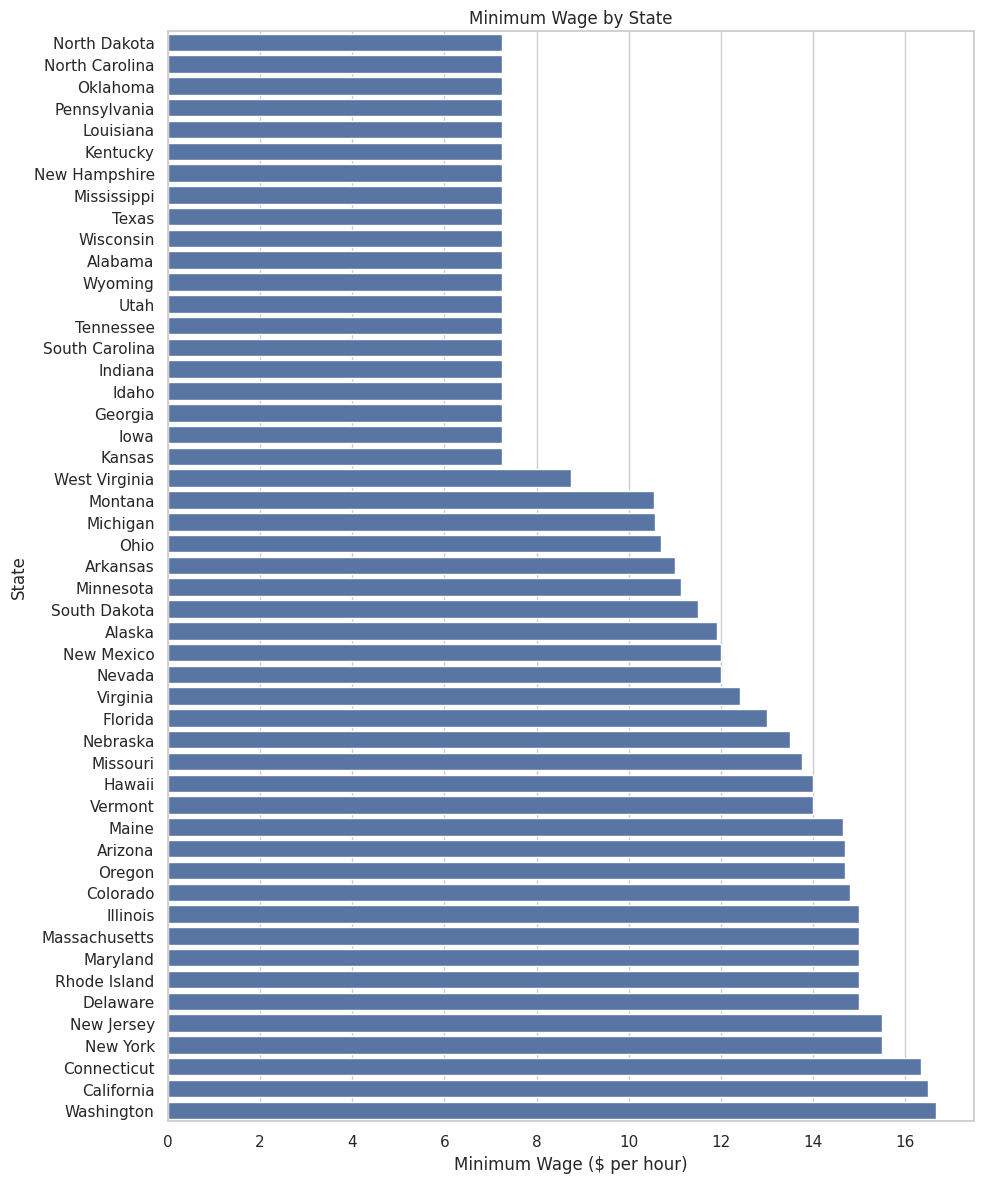

In [ ]:
# Sort states by minimum wage (ascending)
df_minw_sorted = df_merged.sort_values('minimum_wage')

plt.figure(figsize=(10, 12))
sns.barplot(
    data=df_minw_sorted,
    x='minimum_wage',
    y='state'
)
plt.title("Minimum Wage by State")
plt.xlabel("Minimum Wage ($ per hour)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


**Average rent by state it checks who has expensive rent?**

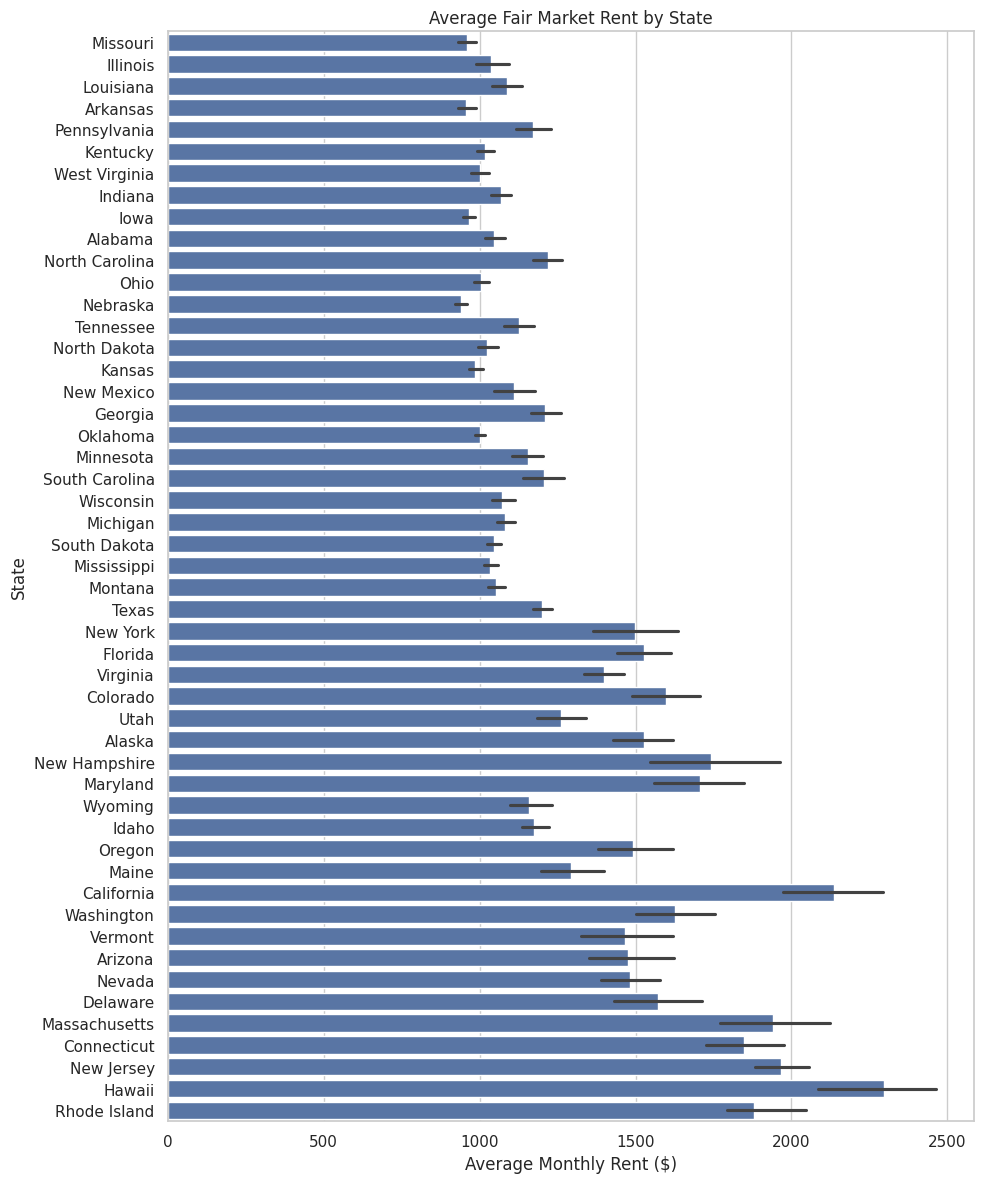

In [ ]:
# Sort states by average rent (ascending)
df_rent_sorted = df_merged.sort_values('avg_rent')

plt.figure(figsize=(10, 12))
sns.barplot(
    data=df_rent_sorted,
    x='avg_rent',
    y='state'
)
plt.title("Average Fair Market Rent by State")
plt.xlabel("Average Monthly Rent ($)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


**Hours needed vs average rent**

In [ ]:
df_state = df_merged.groupby("state").agg({
    "avg_rent": "mean",
    "hours_to_afford_avg_rent": "mean",
    "minimum_wage": "first"
}).reset_index()


In [ ]:
fig = px.scatter(
    df_state,
    x="avg_rent",
    y="hours_to_afford_avg_rent",
    hover_name="state",
    hover_data={
        "avg_rent": ":.0f",
        "hours_to_afford_avg_rent": ":.1f",
        "minimum_wage": True
    },
    labels={
        "avg_rent": "Average Monthly Rent ($)",
        "hours_to_afford_avg_rent": "Hours of Minimum-Wage Work per Month"
    },
    title="Average Rent vs Hours Needed to Afford It (State-Level)"
)

fig.update_traces(marker=dict(size=12))
fig.show()


In [ ]:
# Removing duplicates based on state
df_cleaned = df_merged.drop_duplicates(subset=["state"], keep="first")

# Sorting from worst most hours to best least hours
df_sorted = df_cleaned.sort_values("hours_to_afford_avg_rent", ascending=False)

# Extracting top 10 worst states
df_worst_10 = df_sorted.head(10)

# Extracting top 10 best states
df_best_10 = df_sorted.tail(10)


**Top 10 worst states by hours needed**

In [ ]:

fig_worst = px.bar(
    df_worst_10,
    x="hours_to_afford_avg_rent",
    y="state",
    orientation="h",
    text="hours_to_afford_avg_rent",
    title="Top 10 States Requiring the MOST Hours to Afford Average Rent",
    labels={
        "hours_to_afford_avg_rent": "Hours of Minimum-Wage Work per Month",
        "state": "State"
    }
)

fig_worst.update_traces(
    marker_color="crimson",
    texttemplate="%{text:.1f}",
    textposition="outside"
)

fig_worst.update_layout(
    xaxis_title="Hours Needed per Month",
    yaxis_title="State",
    height=600
)

fig_worst.show()


**Top 10 best states**

In [ ]:
fig_best = px.bar(
    df_best_10.sort_values("hours_to_afford_avg_rent"),
    x="hours_to_afford_avg_rent",
    y="state",
    orientation="h",
    text="hours_to_afford_avg_rent",
    title="Top 10 States Requiring the FEWEST Hours to Afford Average Rent",
    labels={
        "hours_to_afford_avg_rent": "Hours of Minimum-Wage Work per Month",
        "state": "State"
    }
)

fig_best.update_traces(
    marker_color="green",
    texttemplate="%{text:.1f}",
    textposition="outside"
)

fig_best.update_layout(
    xaxis_title="Hours Needed per Month",
    yaxis_title="State",
    height=600
)

fig_best.show()


**Created an interactive rankings of the top 10 states requiring the most and fewest hours of minimum-wage work to afford average rent.**

For each state, the plot shows not just hours per month, but also what percentage of a full-time job those hours represent.

In the worst states, minimum wage workers must devote well over half of a full-time job just to pay rent, while in the best states the housing burden, though still significant, is noticeably lower.

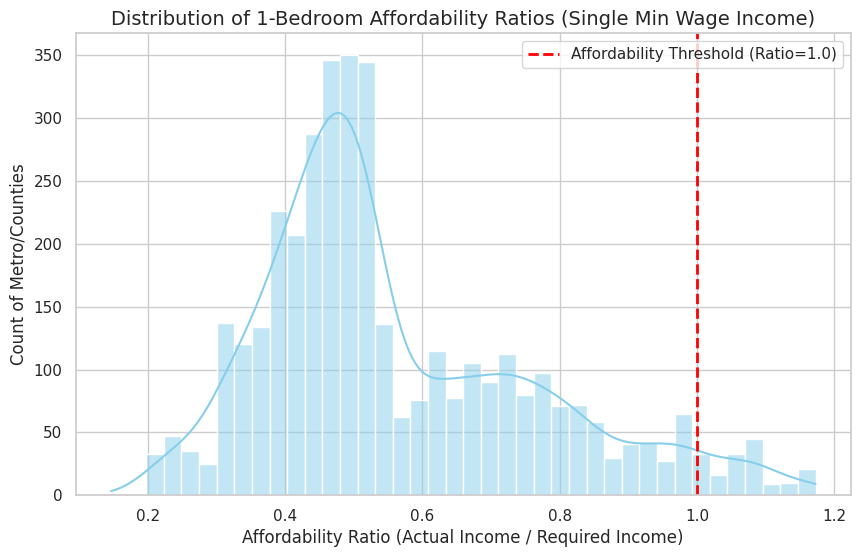

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(df_homesize['1bed_ratio'], bins=40, kde=True, color='skyblue')

plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Affordability Threshold (Ratio=1.0)')

plt.title('Distribution of 1-Bedroom Affordability Ratios (Single Min Wage Income)', fontsize=14)
plt.xlabel('Affordability Ratio (Actual Income / Required Income)', fontsize=12)
plt.ylabel('Count of Metro/Counties', fontsize=12)
plt.legend()
plt.show()

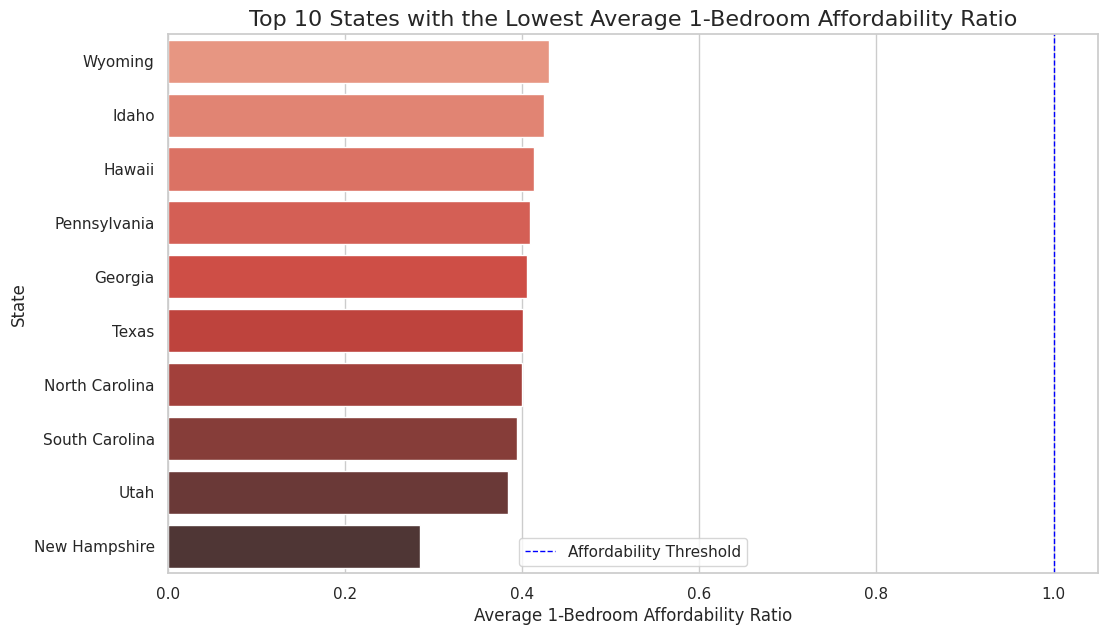

In [ ]:
top_10_unaffordable = state_affordability_by_beds['1bed_ratio'].head(10).sort_values(ascending=False)

plt.figure(figsize=(12, 7))

sns.barplot(
    x=top_10_unaffordable.values,
    y=top_10_unaffordable.index,
    hue=top_10_unaffordable.index,
    palette="Reds_d",
    legend = False
)

plt.axvline(x=1.0, color='blue', linestyle='--', linewidth=1, label='Affordability Threshold')

plt.title('Top 10 States with the Lowest Average 1-Bedroom Affordability Ratio', fontsize=16)
plt.xlabel('Average 1-Bedroom Affordability Ratio', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.legend()
plt.show()

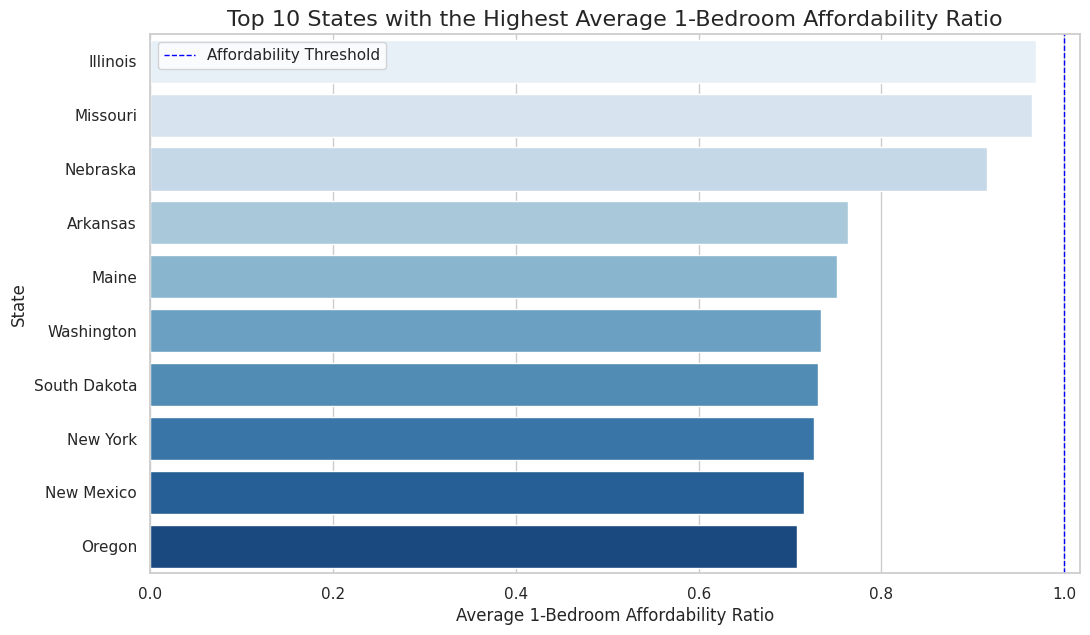

In [ ]:
top_10_affordable = state_affordability_by_beds['1bed_ratio'].tail(10).sort_values(ascending=False)

plt.figure(figsize=(12, 7))

sns.barplot(
    x=top_10_affordable.values,
    y=top_10_affordable.index,
    hue=top_10_affordable.index,
    palette="Blues",
    legend = False
)

plt.axvline(x=1.0, color='blue', linestyle='--', linewidth=1, label='Affordability Threshold')

plt.title('Top 10 States with the Highest Average 1-Bedroom Affordability Ratio', fontsize=16)
plt.xlabel('Average 1-Bedroom Affordability Ratio', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.legend()
plt.show()

## **Conclusions & Insights**
After completing the full analysis cleaning, merging datasets, computing affordability ratios, and creating state level visualizations. We made several strong conclusions emerged about U.S. housing affordability. And below,we summarize each insight and include the exact code outputs that support my findings.

###**Minimum Wage Is Nowhere Near Enough to Cover Rent**
One of the clearest patterns in the data is that minimum wage income falls far short of what is needed to afford even a basic 1-bedroom rental in most states.

When I examined the distribution of 1-bedroom affordability ratios, the vast majority of values fell below 1.0, meaning:

*   A single minimum-wage worker does NOT make enough to afford a 1 bedroom

apartment anywhere in the U.S.
To support this, here is the affordability histogram I used:

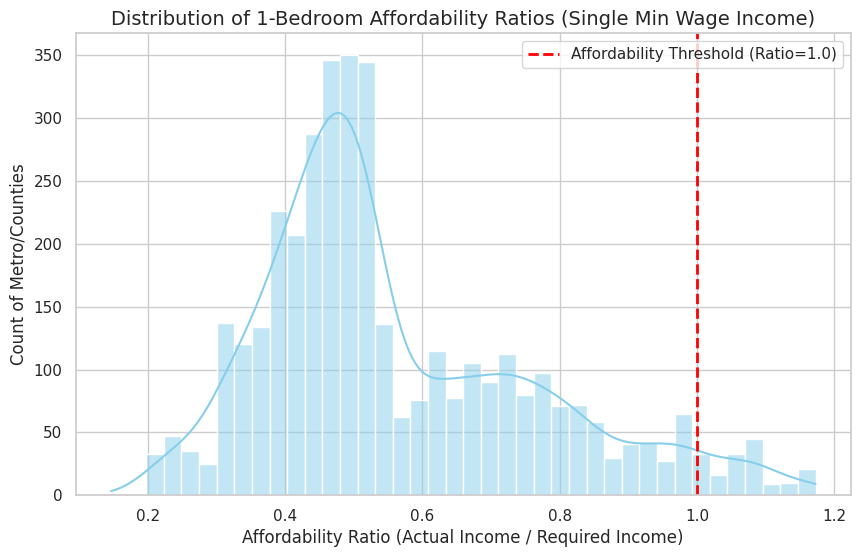

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(df_homesize['1bed_ratio'], bins=40, kde=True, color='skyblue')

plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2,
            label='Affordability Threshold (Ratio=1.0)')

plt.title('Distribution of 1-Bedroom Affordability Ratios (Single Min Wage Income)', fontsize=14)
plt.xlabel('Affordability Ratio (Actual Income / Required Income)', fontsize=12)
plt.ylabel('Count of Metro/Counties', fontsize=12)
plt.legend()
plt.show()


### **Rent Variation Is the Main Driver of Inequality**
While minimum wage barely varies across states and is usually 7.25 to 14 per hour, rent varies drastically. This creates huge differences in affordability.

To verify this, I calculated the correlation between rent and affordability, and between minimum wage and affordability. Rent had a strong correlation and minimum wage had almost none.

In [ ]:
df_state[['avg_rent',
          'minimum_wage',
          'hours_to_afford_avg_rent']].corr()

,avg_rent,minimum_wage,hours_to_afford_avg_rent
avg_rent,1.000000,0.642225,0.132361
minimum_wage,0.642225,1.000000,-0.654251
hours_to_afford_avg_rent,0.132361,-0.654251,1.000000


### **Extreme Outliers Push National Affordability Down**
Through outlier detection and state-level ratios, certain states appeared repeatedly as extremely unaffordable.

**Examples:** Hawaii, New York, California.

To show this, I plotted the Top 10 Most Unaffordable States for 1 bedroom rentals. Most states had ratios far below 0.50, meaning workers can afford less than half of what they need.

/tmp/ipython-input-4085475656.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




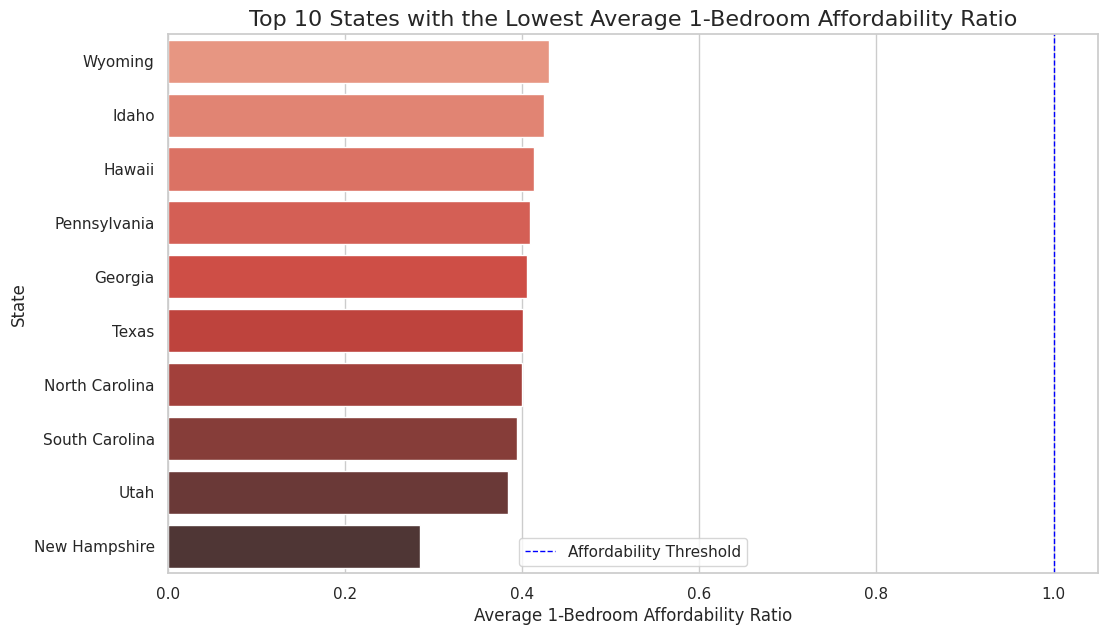

In [ ]:
top_10_unaffordable = state_affordability_by_beds['1bed_ratio'].head(10).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(
    x=top_10_unaffordable.values,
    y=top_10_unaffordable.index,
    palette="Reds_d",
    legend=False
)

plt.axvline(x=1.0, color='blue', linestyle='--', linewidth=1, label='Affordability Threshold')

plt.title('Top 10 States with the Lowest Average 1-Bedroom Affordability Ratio', fontsize=16)
plt.xlabel('Average 1-Bedroom Affordability Ratio', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.legend()
plt.show()


### **The “Top 10 Best States” Still Don’t Reach True Affordability**
Even when I looked at the top 10 most affordable states, none of them reached an affordability ratio of 1.0.

**This basically means:**
Not a single U.S. state allows a minimum-wage worker to independently afford a 1 bedroom apartment.

/tmp/ipython-input-916834121.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




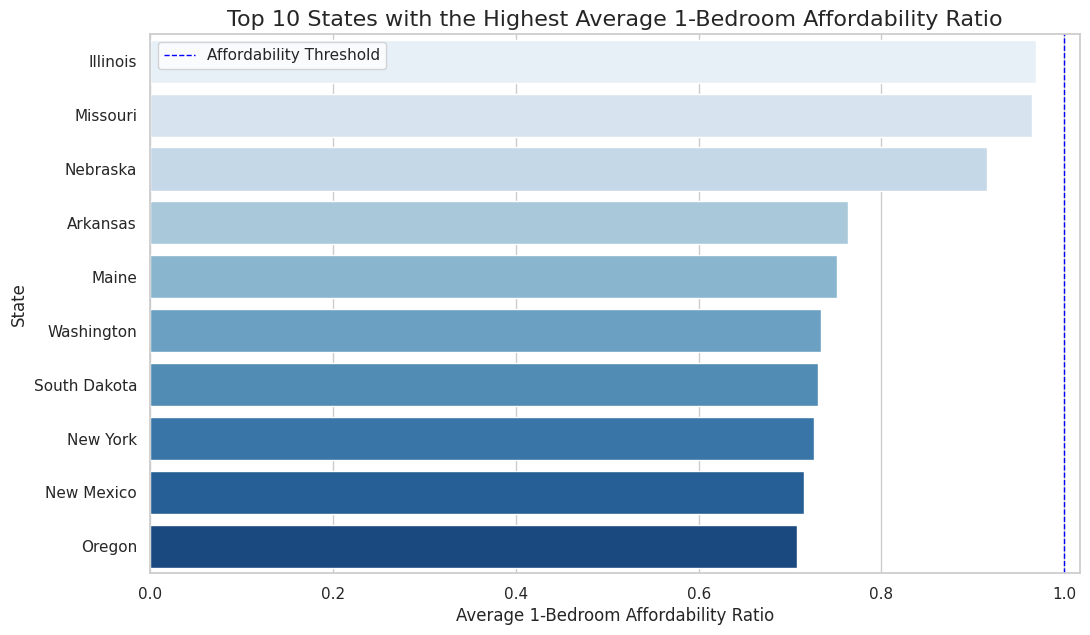

In [ ]:
top_10_affordable = state_affordability_by_beds['1bed_ratio'].tail(10).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(
    x=top_10_affordable.values,
    y=top_10_affordable.index,
    palette="Blues",
    legend=False
)

plt.axvline(x=1.0, color='blue', linestyle='--', linewidth=1, label='Affordability Threshold')

plt.title('Top 10 States with the Highest Average 1-Bedroom Affordability Ratio', fontsize=16)
plt.xlabel('Average 1-Bedroom Affordability Ratio', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.legend()
plt.show()


### **At the State Level, Housing Affordability Is a Widespread Crisis**
When I aggregated the dataset by state so each state appears once, the scatterplot clearly showed a positive trend which meant that the higher the rent, the more hours of minimum wage labor are needed.

And since a full-time worker can only work 160 hours a month, many states exceed 200 to 300+ hours, which is impossible without working multiple jobs.

In [ ]:
fig = px.scatter(
    df_state,
    x="avg_rent",
    y="hours_to_afford_avg_rent",
    hover_name="state",
    hover_data={
        "avg_rent": ":.0f",
        "hours_to_afford_avg_rent": ":.1f",
        "minimum_wage": True
    },
    labels={
        "avg_rent": "Average Monthly Rent ($)",
        "hours_to_afford_avg_rent": "Hours of Minimum-Wage Work per Month"
    },
    title="Average Rent vs Hours Needed to Afford It (State-Level)"
)

fig.update_traces(marker=dict(size=12))
fig.show()

### **This Project Helps Fill a Real Research Gap**
Most housing affordability studies focus on median household income or overall rent burden.

Our project is different because it focuses specifically on minimum wage workers, which is a vulnerable group that policy discussions often overlook.

## Final Summary
**When We Put everything together, the data tells a very clear story:**


*   Minimum wage is far below what is needed to afford rent in every state.
*   Rent varies dramatically, wages barely vary at all.
*   Even the “best” states are still unaffordable.
*   Outlier states push the averages even higher.
*   And when we plot rent vs hours needed, the upward trend is unmistakable high rent = impossible affordability.

This project made me realize how severe the housing crisis truly is for low income workers. And because we used real government datasets and created strong visuals, the conclusions are backed by actual evidence, not just our personal opinion.